In [ ]:
#| default_exp init

# Initialization

These were directly copied from the corresponding notebook.

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

import logging
logging.disable(logging.WARNING)

set_seed(1103)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)
@inplace
def transformi(b):
    b["image"] = [TF.to_tensor(i) for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 1024
dls = DataLoaders.from_dd(dst, bs)
b = next(iter(dls.train))

In [ ]:
def get_layers():
    return [conv(1,8), conv(8,16), conv(16,32), conv(32,64), conv(64,10, act=False), nn.Flatten()]

def get_model():
    return nn.Sequential(*get_layers())

In [ ]:
from torcheval.metrics import MulticlassAccuracy

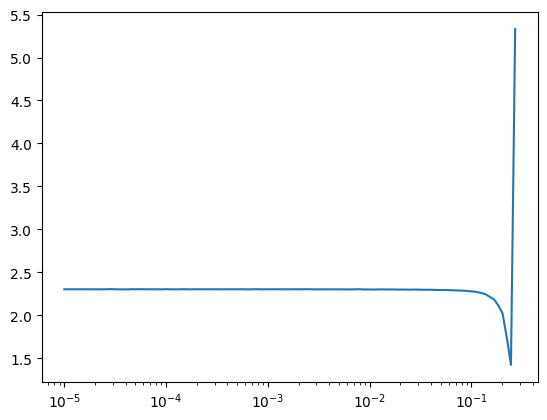

In [ ]:
set_seed(1103)
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(mult=1.1);

In [ ]:
cbs = [DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(True)]

In [ ]:
set_seed(1103)
learn = MomentumLearner(get_model(), dls, F.cross_entropy, 0.25, cbs=cbs)

accuracy,loss,epoch,train
0.385,1.729,0,train
0.714,0.757,0,valid
0.780,0.583,1,train
0.790,0.552,1,valid
0.827,0.464,2,train
0.830,0.467,2,valid


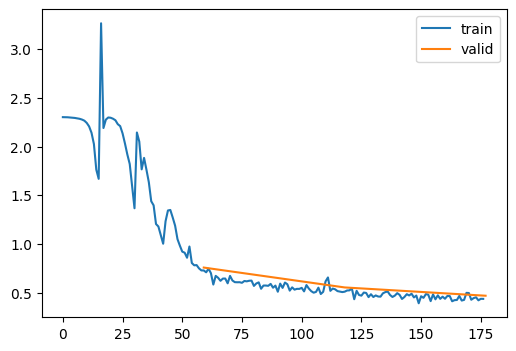

In [ ]:
learn.fit(3);

accuracy,loss,epoch,train
0.385,1.729,0,train
0.714,0.757,0,valid
0.780,0.583,1,train
0.790,0.552,1,valid


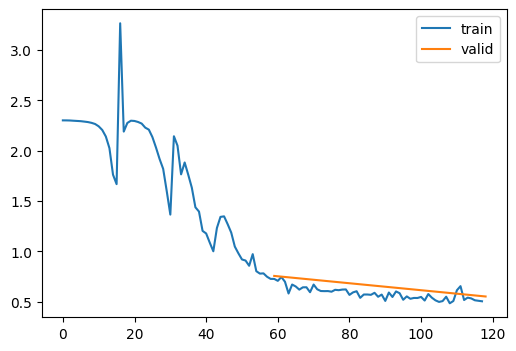

In [ ]:
set_seed(1103)
learn = MomentumLearner(get_model(), dls, F.cross_entropy, 0.25, cbs=cbs)
stats = ActivationStats(lambda x: isinstance(x, nn.Conv2d))
learn.fit(2, cbs=[stats]);

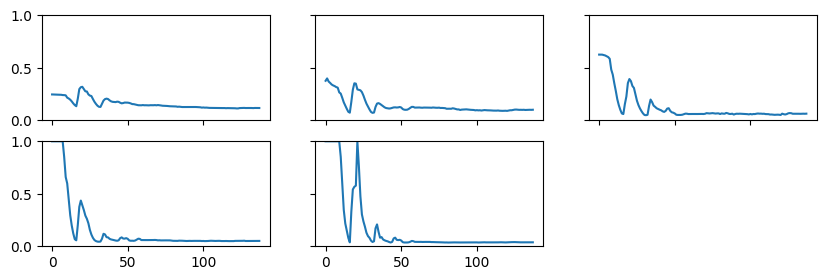

In [ ]:
stats.dead_chart()

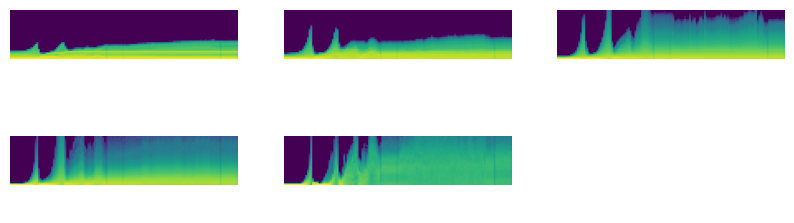

In [ ]:
stats.color_dim()

In [ ]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [ ]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [ ]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
clean_mem()

## Glorot / Xavier init

In [ ]:
x = torch.randn((100, 50))
print(x.mean(), x.std())
for i in range(5): x = x @ torch.randn((50, 50))
print(x.mean(), x.std())
for i in range(45): x = x @ torch.randn((50, 50))
print(x.mean(), x.std())
print(x[:3, :3])

tensor(-0.00) tensor(1.00)
tensor(464.69) tensor(18293.22)
tensor(nan) tensor(nan)
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])


In [ ]:
x = torch.randn((100, 50))
print(x.mean(), x.std())
for i in range(5): x = x @ (torch.randn((50, 50)) * 0.1)
print(x.mean(), x.std())
for i in range(15): x = x @ (torch.randn((50, 50)) * 0.1)
print(x.mean(), x.std())
print(x[:3, :3])

tensor(-0.00) tensor(1.02)
tensor(-0.00) tensor(0.17)
tensor(    0.00) tensor(0.00)
tensor([[-0.00, -0.00, -0.00],
        [ 0.00, -0.00,  0.00],
        [-0.00, -0.00, -0.00]])


In [ ]:
x = torch.randn((100, 50))
mult = torch.tensor(1 / x.shape[1]).sqrt()
print(x.mean(), x.std())
for i in range(5): x = x @ (torch.randn((50, 50)) * mult)
print(x.mean(), x.std())
for i in range(45): x = x @ (torch.randn((50, 50)) * mult)
print(x.mean(), x.std())
for i in range(50): x = x @ (torch.randn((50, 50)) * mult)
print(x.mean(), x.std())
print(x[:3, :3])

tensor(-0.03) tensor(0.98)
tensor(0.00) tensor(1.00)
tensor(-0.01) tensor(0.76)
tensor(-0.01) tensor(0.81)
tensor([[-0.76,  0.56, -0.59],
        [-0.87,  1.18, -1.17],
        [ 0.54,  0.17, -0.16]])


## Kaiming / He init

In [ ]:
x = torch.randn((100, 50))
mult = torch.tensor(1 / x.shape[1]).sqrt()
print(x.mean(), x.std())
for i in range(5): x = F.relu(x @ (torch.randn((50, 50)) * mult))
print(x.mean(), x.std())
for i in range(45): x = F.relu(x @ (torch.randn((50, 50)) * mult))
print(x.mean(), x.std())
for i in range(50): x = F.relu(x @ (torch.randn((50, 50)) * mult))
print(x.mean(), x.std())
print(x[:3, :3])

tensor(0.01) tensor(0.99)
tensor(0.08) tensor(0.13)
tensor(    0.00) tensor(    0.00)
tensor(    0.00) tensor(    0.00)
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [ ]:
x = torch.randn((100, 50))
mult = torch.tensor(2 / x.shape[1]).sqrt()
print(x.mean(), x.std())
for i in range(5): x = F.relu(x @ (torch.randn((50, 50)) * mult))
print(x.mean(), x.std())
for i in range(45): x = F.relu(x @ (torch.randn((50, 50)) * mult))
print(x.mean(), x.std())
for i in range(50): x = F.relu(x @ (torch.randn((50, 50)) * mult))
print(x.mean(), x.std())
print(x[:3, :3])

tensor(0.00) tensor(1.02)
tensor(0.65) tensor(0.97)
tensor(0.02) tensor(0.03)
tensor(0.01) tensor(0.02)
tensor([[0.00, 0.00, 0.08],
        [0.00, 0.00, 0.01],
        [0.00, 0.00, 0.03]])


## Applying an init function

In [ ]:
set_seed(1103)
model = get_model()
model.apply(lambda x: print(type(x).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [ ]:
init.kaiming_normal_?

Signature:
init.kaiming_normal_(
    tensor: torch.Tensor,
    a: float = 0,
    mode: str = 'fan_in',
    nonlinearity: str = 'leaky_relu',
)
Docstring:
Fills the input `Tensor` with values according to the method
described in `Delving deep into rectifiers: Surpassing human-level
performance on ImageNet classification` - He, K. et al. (2015), using a
normal distribution. The resulting tensor will have values sampled from
:math:`\mathcal{N}(0, \text{std}^2)` where

.. math::
    \text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_mode}}}

Also known as He initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    a: the negative slope of the rectifier used after this layer (only
        used with ``'leaky_relu'``)
    mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
        preserves the magnitude of the variance of the weights in the
        forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
        backwards pass.
    nonlinearity

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, nonlinearity="relu")

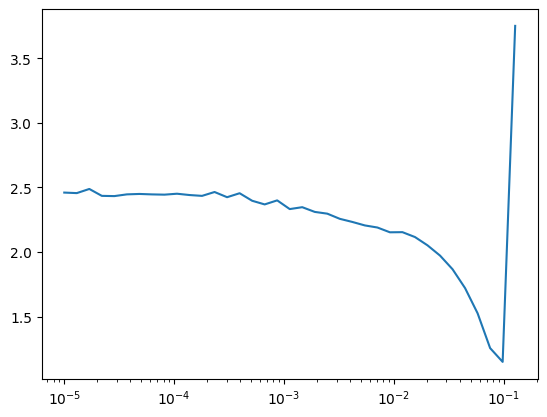

In [ ]:
set_seed(1103)
MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, 0.25, cbs=[DeviceCB()]).lr_find();

accuracy,loss,epoch,train
0.642,1.096,0,train
0.785,0.582,0,valid
0.828,0.480,1,train
0.825,0.481,1,valid


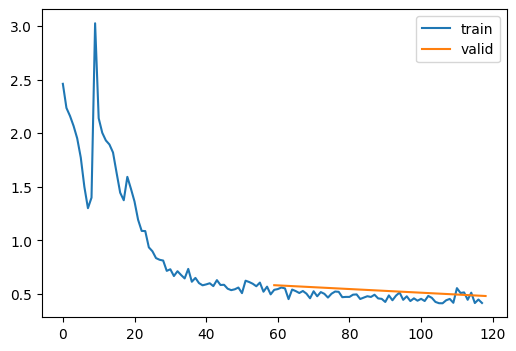

In [ ]:
set_seed(1103)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, 0.09, cbs=cbs)
stats = ActivationStats(lambda x: isinstance(x, nn.Conv2d))
learn.fit(2, cbs=[stats]);

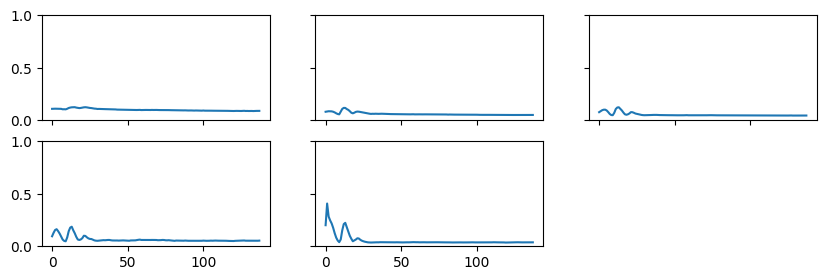

In [ ]:
stats.dead_chart()

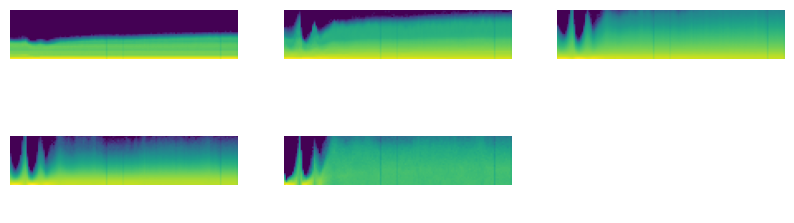

In [ ]:
stats.color_dim()

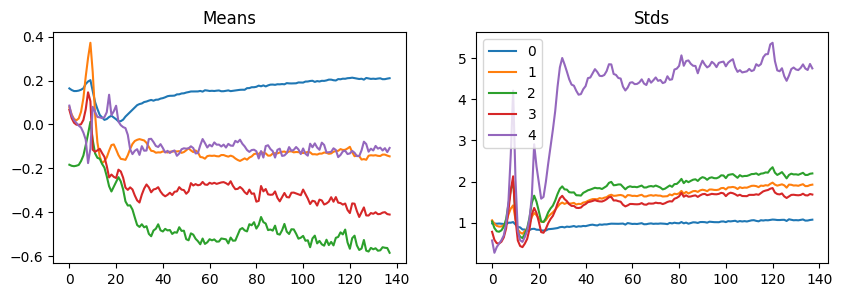

In [ ]:
stats.plot_stats()

## Input normalization

In [ ]:
xb, yb = next(iter(dls.train))
xb.mean(), xb.std()

(tensor(0.28), tensor(0.35))

In [ ]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, transform): fc.store_attr()

    def before_batch(self, learn):
        learn.batch = self.transform(learn.batch)

In [ ]:
xbnorm = (xb - xb.mean()) / xb.std()
xbnorm.mean(), xbnorm.std()

(tensor(    0.00), tensor(1.))

In [ ]:
xmean = xb.mean()
xstd = xb.std()

In [ ]:
def _norm(batch):
    return (batch[0] - xmean) / xstd, batch[1]

accuracy,loss,epoch,train
0.703,0.850,0,train
0.799,0.539,0,valid
0.836,0.452,1,train
0.836,0.447,1,valid


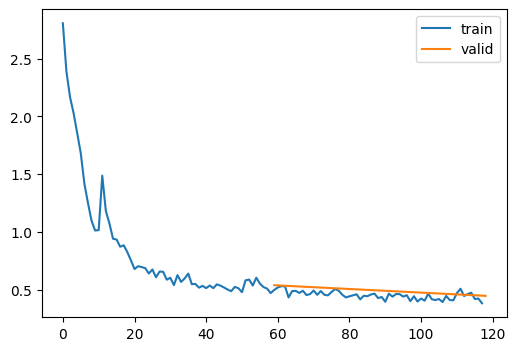

In [ ]:
set_seed(1103)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, 0.09, cbs=cbs)
stats = ActivationStats(lambda x: isinstance(x, nn.Conv2d))
learn.fit(2, cbs=[stats, BatchTransformCB(_norm)]);

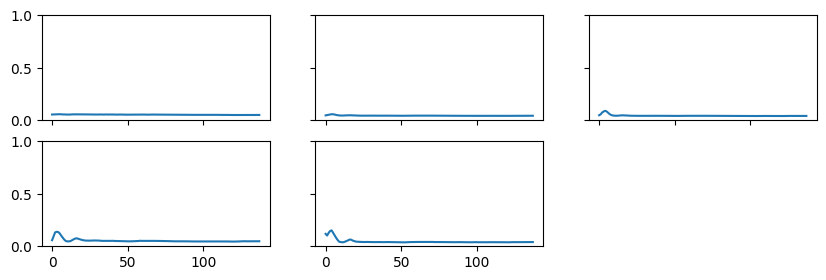

In [ ]:
stats.dead_chart()

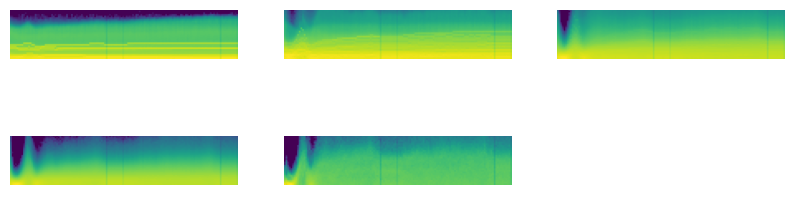

In [ ]:
stats.color_dim()

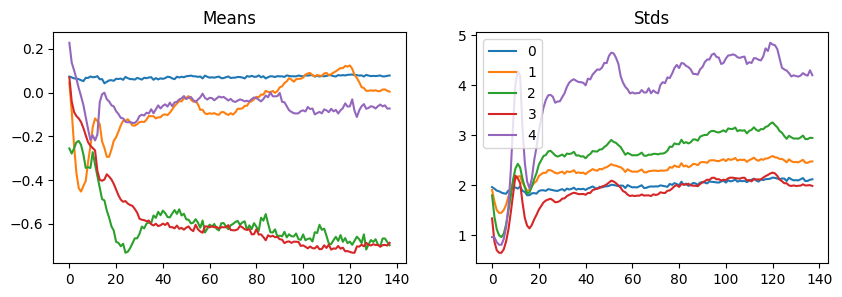

In [ ]:
stats.plot_stats()

In [ ]:
@inplace
def transformi(b):
    b["image"] = [(TF.to_tensor(i) - xmean) / xstd for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 1024
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

accuracy,loss,epoch,train
0.634,1.105,0,train
0.790,0.571,0,valid
0.824,0.485,1,train
0.822,0.479,1,valid
0.847,0.419,2,train
0.843,0.418,2,valid


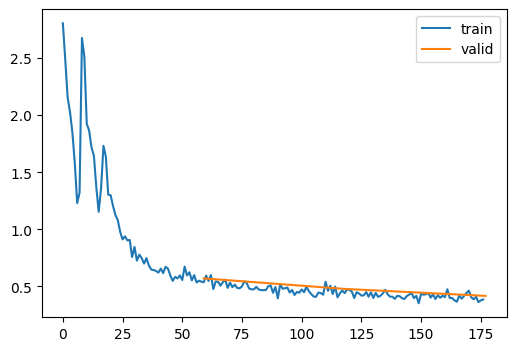

In [ ]:
set_seed(1103)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, 0.15, cbs=cbs)
stats = ActivationStats(lambda x: isinstance(x, nn.Conv2d))
learn.fit(3);

# General ReLU

In [ ]:
for i in range(3):
    print("-------")
    a = torch.randn(20,100,100)
    %timeit -n 500 _=F.relu(a)
    %timeit -n 500 _=F.leaky_relu(a, 0.1)
    %timeit -n 500 _=F.leaky_relu(a, 0.)

-------
13.4 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
14.3 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
20.5 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
-------
12.9 µs ± 898 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
13.6 µs ± 290 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
13.9 µs ± 888 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
-------
12.7 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
13.4 µs ± 268 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
17 µs ± 3.42 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)


In [ ]:
sub = 0
for i in range(3):
    a = torch.randn(20,100,100)
    %timeit -n 500 _ = a-sub
    %timeit -n 500 _ = a-sub if sub else a

17.3 µs ± 2.35 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
16.4 ns ± 0.947 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
22.1 µs ± 880 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
16.4 ns ± 0.999 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
22 µs ± 637 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
16.4 ns ± 0.977 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)


In [ ]:
#| export
class GeneralReLU(nn.Module):
    def __init__(self, leak=0, sub=0, maxv=0):
        assert(leak >= 0)
        assert(sub >= 0)
        assert(maxv >= 0)
        super().__init__()
        fc.store_attr()

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak else F.relu(x)
        if self.sub:
            x -= self.sub
        if self.maxv:
            x = torch.clamp_max_(x, self.maxv)
        return x

In [ ]:
#| export
def plot_func(f, start=-10, end=10, steps=100):
    xs = torch.linspace(start, end, steps)
    plt.plot(xs, f(xs))
    plt.axhline(0, color="black")
    plt.axvline(0, color="black")
    plt.grid()

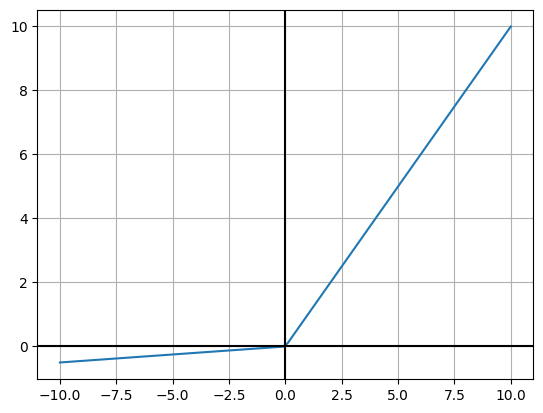

In [ ]:
plot_func(GeneralReLU(0.05))

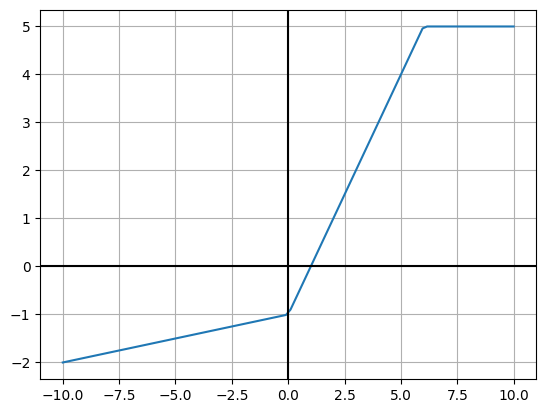

In [ ]:
plot_func(GeneralReLU(0.1, 1, 5))

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    result = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act:
        result = nn.Sequential(result, act())
    return result

In [ ]:
def get_model(act, nfs=[1,8,16,32,64]):
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    model = nn.Sequential(*layers, conv(64, 10, act=False), nn.Flatten())
    return model

In [ ]:
#|export
def init_weights(m, leak):
    if isinstance(m, nn.Conv2d):
        nonlin = "leaky_relu" if leak else "relu"
        init.kaiming_normal_(m.weight, nonlinearity=nonlin, a=leak)

accuracy,loss,epoch,train
0.773,0.642,0,train
0.838,0.455,0,valid
0.860,0.386,1,train
0.858,0.399,1,valid
0.876,0.341,2,train
0.866,0.369,2,valid


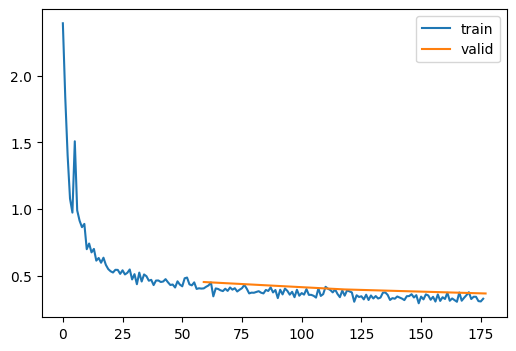

In [ ]:
set_seed(1103)

leak = 0.1
model = get_model(partial(GeneralReLU, leak, 0.5))
model.apply(lambda m: init_weights(m, leak))

stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))
learn = MomentumLearner(model, dls, F.cross_entropy, 0.15, cbs=cbs)
learn.fit(3, cbs=[stats])

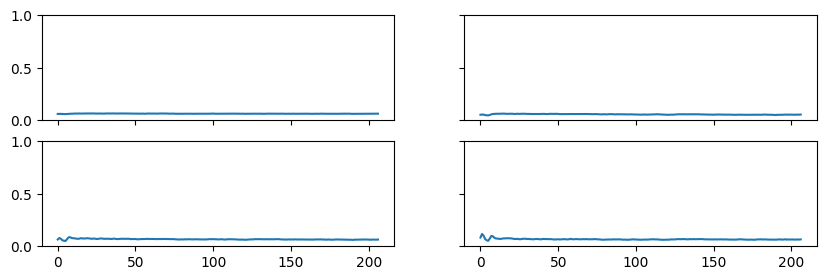

In [ ]:
stats.dead_chart()

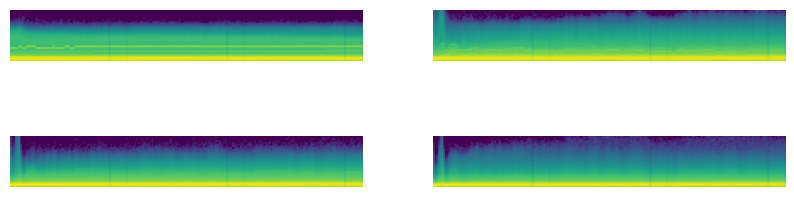

In [ ]:
stats.color_dim()

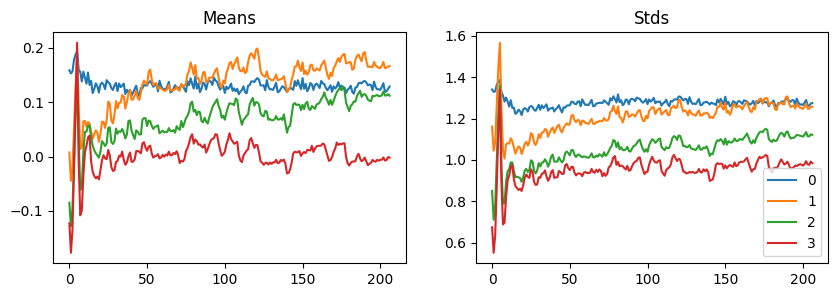

In [ ]:
stats.plot_stats()

# LSUV

In [ ]:
#|export
def _lsuv_stats(hook, mod, inp, outp):
    hook.mean = to_cpu(outp.mean())
    hook.std = to_cpu(outp.std())

In [ ]:
#|export
def lsuv_init(model, m, m_in, xb):
    hook = Hook(m_in, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and hook.mean.abs() > 1e-3 and (hook.std - 1).abs() > 1e-3:
            m.weight /= hook.std
            m.bias -= hook.mean
    hook.remove()
            

In [ ]:
set_seed(1103)
model = get_model(partial(GeneralReLU, leak, 0.5))
convs = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
relus = [m for m in model.modules() if isinstance(m, GeneralReLU)]
to_init = list(zip(convs, relus))
to_init

[(Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
  GeneralReLU()),
 (Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
  GeneralReLU()),
 (Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
  GeneralReLU()),
 (Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
  GeneralReLU())]

In [ ]:
model = model.to(def_device)
xb = xb.to(def_device)
for m, m_in in to_init:
    lsuv_init(model, m, m_in, xb)
xb = to_cpu(xb)

accuracy,loss,epoch,train
0.773,0.642,0,train
0.834,0.459,0,valid
0.859,0.389,1,train
0.858,0.395,1,valid
0.874,0.345,2,train
0.867,0.375,2,valid


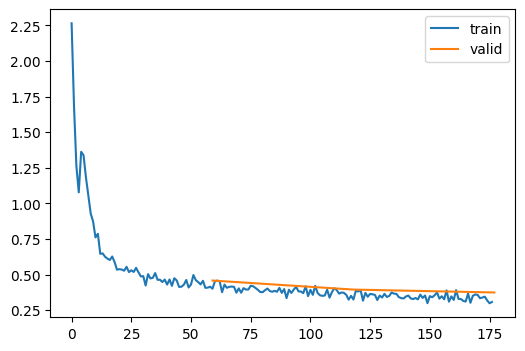

In [ ]:
stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))
learn = MomentumLearner(model, dls, F.cross_entropy, 0.15, cbs=cbs)
learn.fit(3, cbs=[stats])

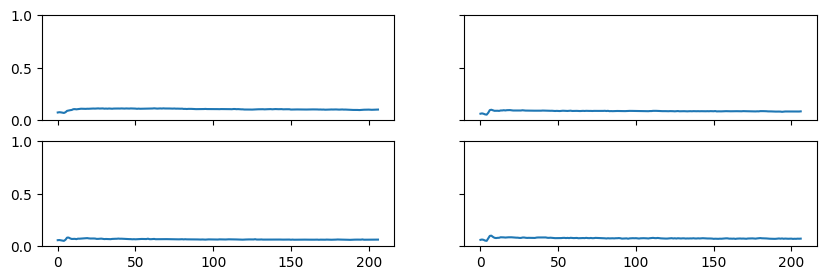

In [ ]:
stats.dead_chart()

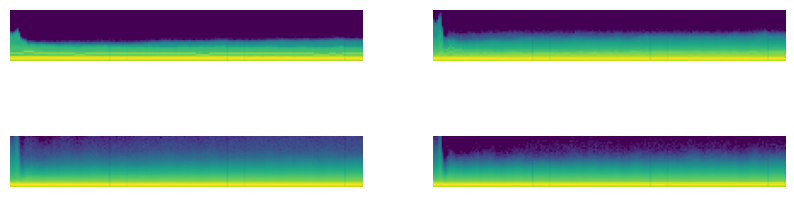

In [ ]:
stats.color_dim()

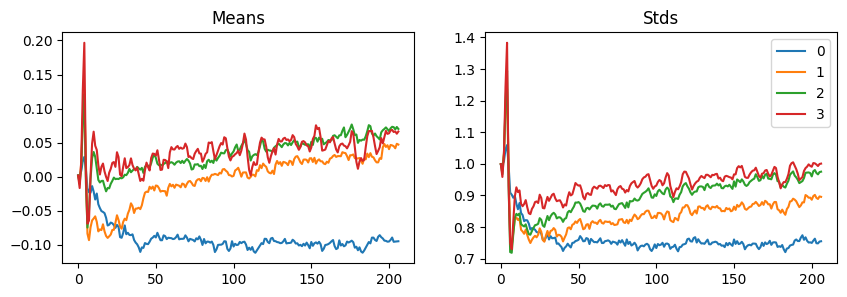

In [ ]:
stats.plot_stats()

# Batch normalization

## LayerNorm

In [ ]:
nn.Parameter?

Init signature: nn.Parameter(data=None, requires_grad=True)
Docstring:     
A kind of Tensor that is to be considered a module parameter.

Parameters are :class:`~torch.Tensor` subclasses, that have a
very special property when used with :class:`Module` s - when they're
assigned as Module attributes they are automatically added to the list of
its parameters, and will appear e.g. in :meth:`~Module.parameters` iterator.
Assigning a Tensor doesn't have such effect. This is because one might
want to cache some temporary state, like last hidden state of the RNN, in
the model. If there was no such class as :class:`Parameter`, these
temporaries would get registered too.

Args:
    data (Tensor): parameter tensor.
    requires_grad (bool, optional): if the parameter requires gradient. Note that
        the torch.no_grad() context does NOT affect the default behavior of
        Parameter creation--the Parameter will still have `requires_grad=True` in
        :class:`~no_grad` mode. See :ref:`lo

In [ ]:
a = torch.randn((4, 3, 2, 1))
torch.mean?

Docstring:
mean(input, *, dtype=None) -> Tensor

Returns the mean value of all elements in the :attr:`input` tensor.

Args:
    input (Tensor): the input tensor.

Keyword args:
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        If specified, the input tensor is casted to :attr:`dtype` before the operation
        is performed. This is useful for preventing data type overflows. Default: None.

Example::

    >>> a = torch.randn(1, 3)
    >>> a
    tensor([[ 0.2294, -0.5481,  1.3288]])
    >>> torch.mean(a)
    tensor(0.3367)

.. function:: mean(input, dim, keepdim=False, *, dtype=None, out=None) -> Tensor
   :noindex:

Returns the mean value of each row of the :attr:`input` tensor in the given
dimension :attr:`dim`. If :attr:`dim` is a list of dimensions,
reduce over all of them.


If :attr:`keepdim` is ``True``, the output tensor is of the same size
as :attr:`input` except in the dimension(s) :attr:`dim` where it is of size 1.
Otherwise, :attr

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-4):
        super().__init__()
        self.eps = eps
        self.std = nn.Parameter(torch.tensor([1.]))
        self.bias = nn.Parameter(torch.tensor([0.]))

    def forward(self, x):
        ms = x.mean(list(range(1, a.dim())), keepdim=True)
        ss = x.std(list(range(1, a.dim())), keepdim=True)
        x = (x - ms) / (ss + self.eps)
        x = x * self.std + self.bias
        return x

In [ ]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None:
        bias = not isinstance(norm, nn.BatchNorm2d)
            
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)]
    if act:
        layers.append(act())
    if norm:
        layers.append(norm(nf))
    result = nn.Sequential(*layers)
    return result

In [ ]:
conv(2, 2, norm=partial(LayerNorm, 3))

Sequential(
  (0): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): LayerNorm()
)

In [ ]:
#|export
def get_model(act=nn.ReLU, nfs=[1,8,16,32,64], norm=None, bias=None):
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm, bias=bias) for i in range(len(nfs)-1)]
    model = nn.Sequential(*layers, conv(64, 10, act=False), nn.Flatten())
    return model

accuracy,loss,epoch,train
0.782,0.606,0,train
0.840,0.450,0,valid
0.858,0.391,1,train
0.850,0.417,1,valid
0.873,0.348,2,train
0.864,0.381,2,valid


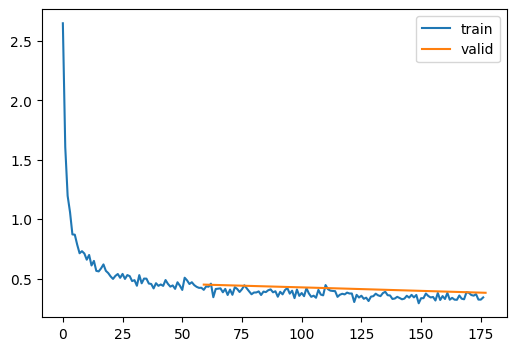

In [ ]:
set_seed(1103)

model = get_model(act=partial(GeneralReLU, leak, 0.5), norm=LayerNorm)
model.apply(lambda m: init_weights(m, 0))

stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))
learn = MomentumLearner(model, dls, F.cross_entropy, 0.15, cbs=cbs)
learn.fit(3, cbs=[stats])

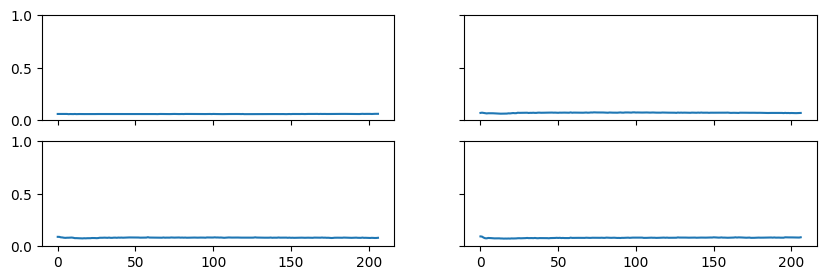

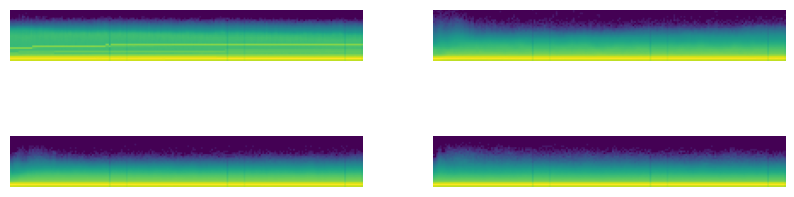

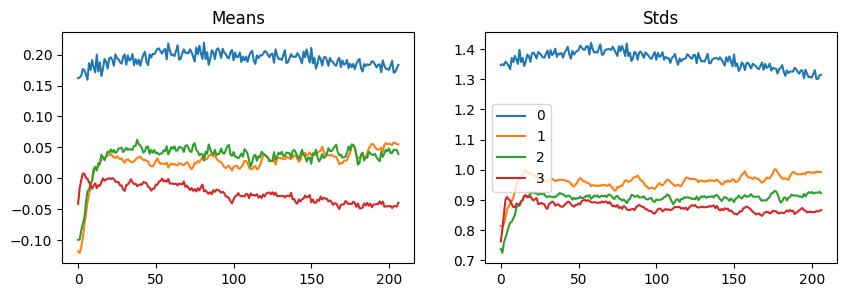

In [ ]:
stats.dead_chart()
stats.color_dim()
stats.plot_stats()

## BatchNorm

In [ ]:
torch.lerp(torch.tensor(1.), torch.tensor(2.), 0.1)

tensor(1.10)

In [ ]:
nn.Module.register_buffer?

Signature:
nn.Module.register_buffer(
    self,
    name: str,
    tensor: Optional[torch.Tensor],
    persistent: bool = True,
) -> None
Docstring:
Adds a buffer to the module.

This is typically used to register a buffer that should not to be
considered a model parameter. For example, BatchNorm's ``running_mean``
is not a parameter, but is part of the module's state. Buffers, by
default, are persistent and will be saved alongside parameters. This
behavior can be changed by setting :attr:`persistent` to ``False``. The
only difference between a persistent buffer and a non-persistent buffer
is that the latter will not be a part of this module's
:attr:`state_dict`.

Buffers can be accessed as attributes using given names.

Args:
    name (str): name of the buffer. The buffer can be accessed
        from this module using the given name
    tensor (Tensor or None): buffer to be registered. If ``None``, then operations
        that run on buffers, such as :attr:`cuda`, are ignored. If ``No

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-4):
        super().__init__()
        self.mom = mom
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer("stds", torch.ones(1, nf, 1, 1))
        self.register_buffer("means", torch.zeros(1, nf, 1, 1))

    def update_stats(self, x):
        means = x.mean((0, 2, 3), keepdim=True)
        stds = x.std((0, 2, 3), keepdim=True)
        self.means.lerp_(means, self.mom)
        self.stds.lerp_(stds, self.mom)
        return means, stds

    def forward(self, x):
        if self.training:
            with torch.no_grad():
                ms, ss = self.update_stats(x)
        else:
            ms = self.means
            ss = self.stds
        x = (x - ms) / (ss + self.eps)
        x = x * self.mults + self.adds
        return x

accuracy,loss,epoch,train
0.787,0.593,0,train
0.844,0.424,0,valid
0.866,0.370,1,train
0.858,0.386,1,valid
0.881,0.329,2,train
0.867,0.360,2,valid


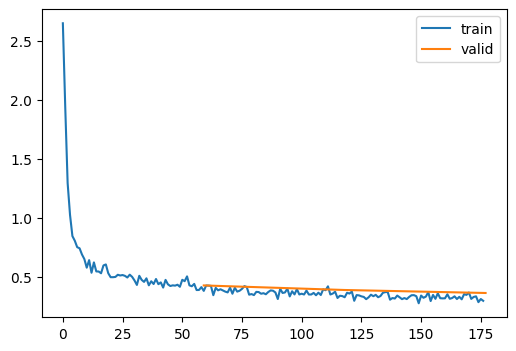

In [ ]:
set_seed(1103)

model = get_model(act=partial(GeneralReLU, leak, 0.5), norm=BatchNorm, bias=False)
model.apply(lambda m: init_weights(m, 0))

stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))
learn = MomentumLearner(model, dls, F.cross_entropy, 0.15, cbs=cbs)
learn.fit(3, cbs=[stats])

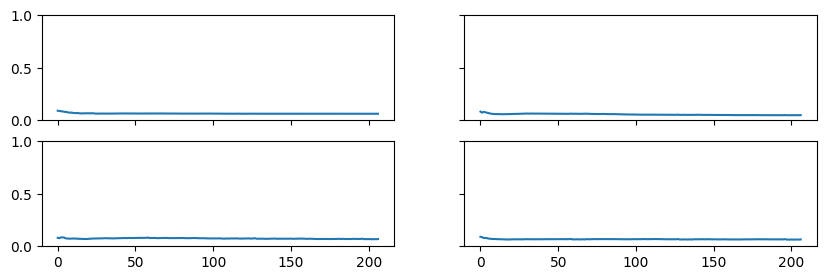

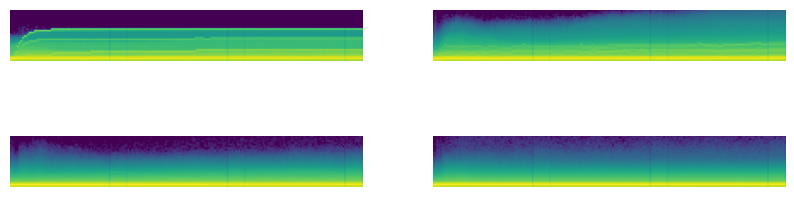

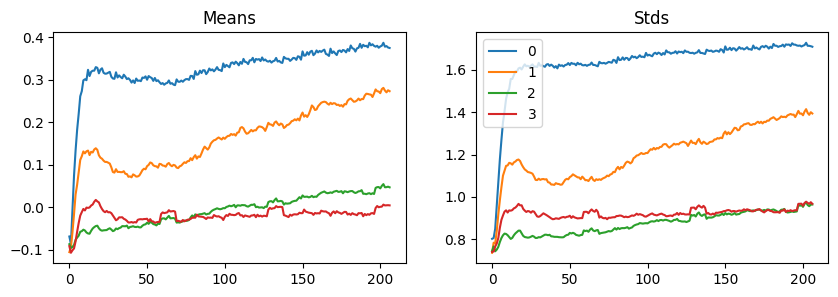

In [ ]:
stats.dead_chart()
stats.color_dim()
stats.plot_stats()

# Towards 90%

accuracy,loss,epoch,train
0.834,0.458,0,train
0.844,0.430,0,valid
0.881,0.326,1,train
0.863,0.382,1,valid
0.894,0.287,2,train
0.871,0.355,2,valid


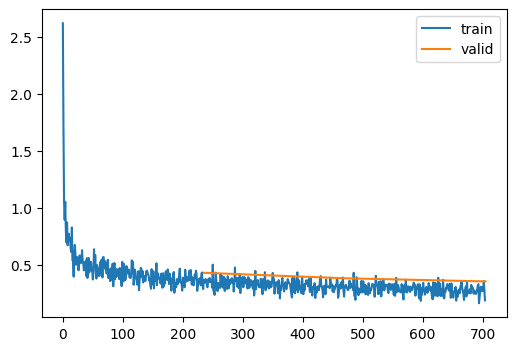

In [ ]:
dls = DataLoaders.from_dd(dst, 256)

set_seed(1103)
model = get_model(act=partial(GeneralReLU, leak, 0.5), norm=nn.BatchNorm2d, bias=False)
model.apply(lambda m: init_weights(m, leak))
learn = MomentumLearner(model, dls, F.cross_entropy, 0.15, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.916,0.231,0,train
0.895,0.294,0,valid
0.921,0.218,1,train
0.897,0.292,1,valid


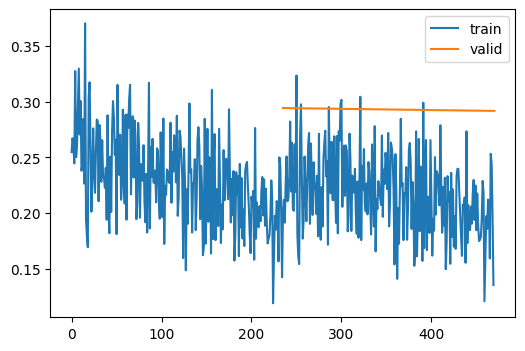

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, 0.01, cbs=cbs)
learn.fit(2)

accuracy,loss,epoch,train
0.924,0.211,0,train
0.898,0.290,0,valid
0.925,0.209,1,train
0.898,0.290,1,valid


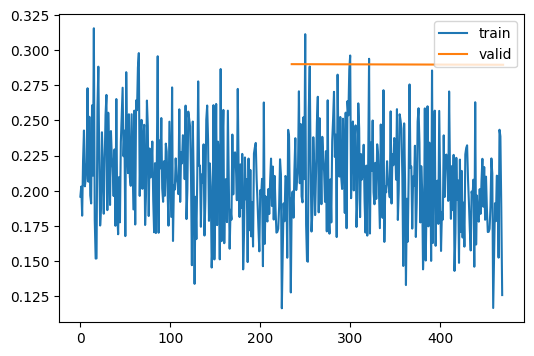

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, 0.002, cbs=cbs)
learn.fit(2)

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()